# A simple model implementation


In [1]:
import warnings

import numpy as np

from seapodym_lmtl_python.configuration.no_transport.parameter_forcing import ForcingUnit
from seapodym_lmtl_python.configuration.no_transport.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapodym_lmtl_python.configuration.no_transport.parameters import (
    ForcingParameters,
    FunctionalGroups,
    NoTransportParameters,
)
from seapodym_lmtl_python.logging.custom_logger import set_critical, set_debug, set_error, set_verbose, set_warning
from seapodym_lmtl_python.model.no_transport_model import NoTransportModel

In [2]:
path_forcing = (
    "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl-Fphy_PT1D-i_1709010880580.nc"
)
path_bio = "/Users/ash/Documents/Workspaces/Data/phd/cmems_mod_glo_bgc_my_0.083deg-lmtl_PT1D-i_1709007157635.nc"

> Set the verbosity of the program.


In [3]:
MODE = 4

# ------------ #
if MODE == 1:
    set_debug()
elif MODE == 2:
    set_verbose()
elif MODE == 3:
    set_warning()
elif MODE == 4:
    set_error()
    warnings.filterwarnings("ignore")
else:
    set_critical()
    warnings.filterwarnings("ignore")

## Initialize the functional groups


In [4]:
f_groups = []

# By functional group
day_layer = [1, 2, 2, 3, 3, 3]
night_layer = [1, 2, 1, 3, 2, 1]
energy_transfert = [0.17, 0.1, 0.22, 0.18, 0.13, 0.2]
tr_max = [2, 3, 4, 5, 6, 7]

for dl, nl, ec, trm in zip(day_layer, night_layer, energy_transfert, tr_max):
    fg_f_param = FunctionalGroupUnitRelationParameters(
        inv_lambda_max=2109,
        inv_lambda_rate=0.125,
        temperature_recruitment_rate=-0.125,
        cohorts_timesteps=np.arange(1, trm + 1),
        temperature_recruitment_max=np.sum(np.arange(1, trm + 1)),
    )
    fg_m_param = FunctionalGroupUnitMigratoryParameters(
        day_layer=dl,
        night_layer=nl,
    )
    f_groups.append(
        FunctionalGroupUnit(
            name=f"D{dl}N{nl}",
            migratory_type=fg_m_param,
            functional_type=fg_f_param,
            energy_transfert=0.0042 * ec,
        )
    )
f_groups = FunctionalGroups(functional_groups=f_groups)

p_param = ForcingParameters(
    temperature=ForcingUnit.from_path(forcing=path_forcing, name="T", resolution=0.08333),
    primary_production=ForcingUnit.from_path(forcing=path_bio, name="npp", resolution=0.08333),
)

parameters = NoTransportParameters(
    functional_groups_parameters=f_groups,
    forcing_parameters=p_param,
)

## Initialize the model


In [5]:
my_class = NoTransportModel(configuration=parameters)
my_class.generate_configuration()
my_class.state

<xarray.Dataset> Size: 44MB
Dimensions:                       (functional_group: 6, depth: 3, latitude: 24,
                                   longitude: 24, time: 4748, cohort: 8)
Coordinates:
  * functional_group              (functional_group) int64 48B 0 1 2 3 4 5
  * depth                         (depth) float32 12B 1.0 2.0 3.0
  * latitude                      (latitude) float32 96B 22.08 22.17 ... 24.0
  * longitude                     (longitude) float32 96B -159.0 ... -157.1
  * time                          (time) datetime64[ns] 38kB 2010-01-01 ... 2...
  * cohort                        (cohort) int64 64B 0 1 2 3 4 5 6 7
Data variables: (12/17)
    name                          (functional_group) <U4 96B 'D1N1' ... 'D3N1'
    energy_transfert              (functional_group) float64 48B 0.000714 ......
    inv_lambda_max                (functional_group) float64 48B 2.109e+03 .....
    inv_lambda_rate               (functional_group) float64 48B 0.125 ... 0.125
    temperature_recruitment_max   (functional_group) float64 48B 3.0 ... 28.0
    temperature_recruitment_rate  (functional_group) float64 48B -0.125 ... -...
    ...                            ...
    resolution_latitude           float64 8B 0.08333
    resolution_longitude          float64 8B 0.08333
    timesteps_number              (functional_group, cohort) float64 384B 1.0...
    min_timestep                  (functional_group, cohort) float64 384B 1.0...
    max_timestep                  (functional_group, cohort) float64 384B 1.0...
    mean_timestep                 (functional_group, cohort) float64 384B 1.0...

In [6]:
my_class.initialize()
my_class.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53872/status,
Dashboard: http://127.0.0.1:53872/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53873,Workers: 4
Dashboard: http://127.0.0.1:53872/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53887,Total threads: 2
Dashboard: http://127.0.0.1:53889/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53876,


## Compute pre-production

This part is computed before the production step. All part of the process that can be pre-computed in parallele should be done here.


In [7]:
my_class.pre_production()

## Compute production

This step is time dependent.


In [8]:
my_class.production()

## Here we compute the output of the model


In [9]:
my_class.post_production()

## Plotting the results


In [10]:
biomass = my_class.state.biomass.load()

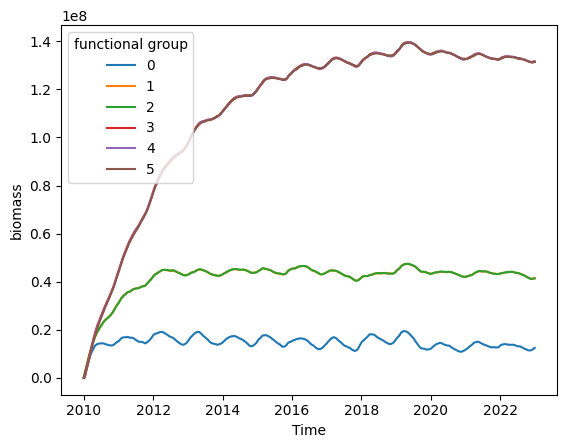

In [11]:
biomass.cf.sum(("X", "Y")).cf.plot.line(x="T", hue="functional_group")